### 1. Imports

In [1]:
import os
import pandas as pd
import numpy as np
from lcfunctions import download_alerce_lc, download_lasair_lc, display_lightcurve
from lcfunctions import lasair_clean, load_lasair_lc
from scipy.signal import find_peaks
from scipy.stats import linregress
from featureextractor import FeatureExtractor
from raw_processing import label_schemes
import warnings
warnings.filterwarnings("ignore")

### 2. Load dataframe of AAVSO CVs in ZTF

In [2]:
# Load dataset
# df_ZTF_CVs = pd.read_csv('../processed_data/AAVSOCVsZTFxmatch_21032023_BTS_labelled.csv')
cvs_df = pd.read_csv('../processed_data/AAVSOCVsZTFxmatch_21032023_BTS_manual_labelled.csv')

# Process the dataframe
dataset = label_schemes(cvs_df)
dataset

,oid_ztf,oid_aavso,type_aavso,ra,dec,Eclipsing,CV_Types,CV_subtypes,CV_subsubtypes,eclipse_clear,manual_label,Clarity,labels_1,labels_2,labels_3,labels_4
0,ZTF18abryuah,ASASSN-19dp,AM,35.745917,43.653639,0,polar,NaN,NaN,0.0,AM_Her,1.0,polar,polar,polar,magnetic
1,ZTF18abtrvgp,BMAM-V789,AM,38.492292,41.623972,0,polar,NaN,NaN,0.0,AM_Her,1.0,polar,polar,polar,magnetic
2,ZTF17aaaehby,CSS 091026:002637+242916,AM,6.654417,24.487694,0,polar,NaN,NaN,0.0,AM_Her,1.0,polar,polar,polar,magnetic
3,ZTF18abgjgiq,MGAB-V3453,AM,8.972375,43.561528,0,polar,NaN,NaN,0.0,AM_Her,1.0,polar,polar,polar,magnetic
4,ZTF18abumlux,MGAB-V3769,AM,353.638167,40.430611,0,polar,NaN,NaN,0.0,AM_Her,1.0,polar,polar,polar,magnetic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5703,ZTF22aazmooy,NaN,N,10.539250,41.258667,0,nova,NaN,NaN,0.0,nova_decline,1.0,nova_decline,nova,nova,nova
5704,ZTF22abfxmpc,NaN,N,10.625167,41.936806,0,nova,NaN,NaN,0.0,nova,1.0,nova,nova,nova,nova
5705,ZTF22abnrgno,NaN,N,10.941000,41.266278,0,nova,NaN,NaN,0.0,nova,1.0,nova,nova,nova,nova
5706,ZTF22abtltcw,NaN,N,10.357167,40.739806,0,nova,NaN,NaN,0.0,nova_decline,1.0,nova_decline,nova,nova,nova


In [3]:
# List of objects.
lst = dataset.oid_aavso.to_list()
# Check length of objects list
print(f'Length of list of objects: {len(lst)}')

Length of list of objects: 5708


### Display light curves

In [4]:
date = '2023_03_25'

manuallist = False

# Apply errorbars
error = False
start = 0
end = 0
column = 'labels_1'
objclass = 'nova_decline'

if error == True:
        errCollasair1 = 'sigmapsf'
        errCollasair2 = 'dc_sigmag'
else:
    errCollasair1 = None
    errCollasair2 = None

# objlist = dataset[dataset[column].str.contains('UGSS', na=False)]['oid_ztf'].iloc[start:end]
# objtype = dataset[dataset[column].str.contains('UGSS', na=False)]['type_aavso'].iloc[start:end]
objlist = dataset[dataset[column].isin([objclass])]['oid_ztf'].iloc[start:end]
objtype = dataset[dataset[column].isin([objclass])]['type_aavso'].iloc[start:end]
# objlist = dataset[dataset[column]>0]['oid_ztf'].iloc[start:end]
# objtype = dataset[dataset[column]>0]['type_aavso'].iloc[start:end]

if manuallist==True:
     objlist = ['ZTF18abajshu','ZTF18aagrgoe','ZTF18abchhxd','ZTF18aabfcyi','ZTF18abnzbxh','ZTF18acrsmyu','ZTF21abhrevv',
                'ZTF18abavrji','ZTF18aanwrti','ZTF18aammncw','ZTF19abzzuin','ZTF18acyerom','ZTF20abgbxco','ZTF18achemir',
                'ZTF18abmaqoi','ZTF18adlkmio','ZTF18abiwtyk','ZTF18aaueblh','ZTF18aakvuwy','ZTF18abcnbki','ZTF18abakkox']

i=0
for object, type in zip(objlist, objtype):
    print(i, object, type)
    
    # Display lasair difference magnitude and apparent magnitude light curves.
    lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_{date}')
    lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)

    # print('Lasair difference magnitude')
    # display_lightcurve(lc_lasair,x='jd',y='magpsf',errorCol=errCollasair1)
    print('Lasair apparent magnitude')
    display_lightcurve(lc_lasair_appmag,x='jd',y='dc_mag',errorCol=errCollasair2)
    i+=1


### Extract custom features

In [5]:
from scipy.signal import find_peaks
from scipy.stats import linregress
import numpy as np

objlist = ['ZTF18aanwrti','ZTF18abmaqoi','ZTF18aabfcyi','ZTF18aakvuwy','ZTF18abajshu','ZTF20abgbxco','ZTF21abhrevv',
           'ZTF18aagrgoe','ZTF18abchhxd']
objlist = dataset['oid_ztf'].to_list()[0:10]
feature_df = pd.DataFrame()
for obj in objlist:
    type = dataset[dataset['oid_ztf']==obj]['type_aavso'].iloc[0]
    print(obj, type)

    # Load and process lasair light curve
    lc_test = load_lasair_lc(oid=obj, path=f'../lightcurves_dataset/lasair_{date}')
    lc_appmag_test = lasair_clean(lc_test, limit=25, magerrlim=1)

    # Create a copy of the light curve
    lc = lc_appmag_test.copy()

    fe = FeatureExtractor(lc=lc)
    feets = fe.extract_feets()
    custom = fe.extract_custom()
    
    # Conactenate custom features to feets
    features_single = pd.concat([feets, custom], axis=1)

    # Add features to dataframe
    feature_df = feature_df.append(features_single, ignore_index=True)


  

ZTF18abryuah AM
ZTF18abtrvgp AM
ZTF17aaaehby AM
ZTF18abgjgiq AM
ZTF18abumlux AM
ZTF18absgnqy AM
ZTF19abisjkc AM
ZTF18abwvggo AM
ZTF18aaxdlbl AM
ZTF18absgzlu AM


### Save the test dataframe

In [6]:
# Add source data to the dataframe
lc_features_df = pd.concat([dataset, feature_df], axis=1)

# Save the dataframe
lc_features_df.to_csv(f'../processed_data/lc_features_test.csv', index=False)

# Load the dataframe
lc_features_df = pd.read_csv(f'../processed_data/lc_features_test.csv')

lc_features_df

,oid_ztf,oid_aavso,type_aavso,ra,dec,Eclipsing,CV_Types,CV_subtypes,CV_subsubtypes,eclipse_clear,...,pnts_leq_median-2mag_r,pnts_leq_median-5mag_r,pnts_geq_median+1mag_r,pnts_geq_median+2mag_r,pnts_geq_median+3mag_r,clr_mean,clr_median,clr_std,clr_bright,clr_faint
0,ZTF18abryuah,ASASSN-19dp,AM,35.745917,43.653639,0,polar,NaN,NaN,0.0,...,0.000000,0.0,0.176316,0.013158,0.0,0.633883,0.553139,0.494722,0.431294,0.283021
1,ZTF18abtrvgp,BMAM-V789,AM,38.492292,41.623972,0,polar,NaN,NaN,0.0,...,0.000000,0.0,0.162500,0.162500,0.0,0.689769,0.931386,0.886252,0.861821,-1.252753
2,ZTF17aaaehby,CSS 091026:002637+242916,AM,6.654417,24.487694,0,polar,NaN,NaN,0.0,...,0.003846,0.0,0.076923,0.000000,0.0,0.312823,0.328959,0.659670,0.396081,0.173051
3,ZTF18abgjgiq,MGAB-V3453,AM,8.972375,43.561528,0,polar,NaN,NaN,0.0,...,0.000000,0.0,0.317647,0.035294,0.0,-0.009772,0.019568,0.481754,-0.174834,-0.175305
4,ZTF18abumlux,MGAB-V3769,AM,353.638167,40.430611,0,polar,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5703,ZTF22aazmooy,NaN,N,10.539250,41.258667,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5704,ZTF22abfxmpc,NaN,N,10.625167,41.936806,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5705,ZTF22abnrgno,NaN,N,10.941000,41.266278,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5706,ZTF22abtltcw,NaN,N,10.357167,40.739806,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Get Gaia DR3 data

In [8]:
from metadatafeatures import gaiadr3append

gaia_df = gaiadr3append(dataset,'oid_ztf')


INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
500 Error 500:
Can not execute the following SQL: 
DROP TABLE user_dmistry.ast_table
Because: ERROR: table "ast_table" does not exist
500 Error 500:
Can not execute the following SQL: 
DROP TABLE user_dmistry.xmatch_table
Because: ERROR: table "xmatch_table" does not exist
Sending pytable.
Uploaded table 'ast_table'.
Retrieving table 'user_dmistry.ast_table'
Table 'user_dmistry.ast_table' updated.
INFO: Query finished. [astroquery.utils.tap.core]
Table 'ast_table' deleted.
Removed jobs: '['1683736853469O']'.
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]
INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
500 Error 500:
Can not execute the following SQL: 
DROP TABLE user_dmistry.ast_table
Because: ERROR: table "ast_table" does not exist
500 Error 5

In [12]:
gaia_df.columns.to_list()
gaia_df[['phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag']]

,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
0,20.278933,20.582287,19.494114
1,20.701881,21.347887,20.135788
2,18.102013,18.253174,17.665977
3,16.243567,16.597261,15.648869
4,20.462353,20.971989,19.564260
...,...,...,...
5703,NaN,NaN,NaN
5704,NaN,NaN,NaN
5705,NaN,NaN,NaN
5706,NaN,NaN,NaN


In [17]:
# Make some more columns from gaia data
from metadatafeatures import distance, absmag

# Add distance column
gaia_df['distance'] = distance(gaia_df['parallax'])
# Add absolute g magnitude column
gaia_df['absmag'] = absmag(gaia_df['phot_g_mean_mag'], gaia_df['distance'])
# Add absolute bp magnitude column
gaia_df['absmag_bp'] = absmag(gaia_df['phot_bp_mean_mag'], gaia_df['distance'])
# Add absolute rp magnitude column
gaia_df['absmag_rp'] = absmag(gaia_df['phot_rp_mean_mag'], gaia_df['distance'])

# Save dataframe
gaia_df.to_csv(f'../processed_data/gaia_df_test.csv', index=False)

# Load dataframe
gaia_df = pd.read_csv(f'../processed_data/gaia_df_test.csv')

gaia_df

,oid_ztf,oid_aavso,type_aavso,ra,dec,Eclipsing,CV_Types,CV_subtypes,CV_subsubtypes,eclipse_clear,...,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,ra_prop,dec_prop,distance,absmag,absmag_bp,absmag_rp
0,ZTF17aabpjjg,MGAB-V1107,UG,349.877167,51.838167,0,dwarf_nova,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,349.877166,51.838167,-12998.128381,NaN,NaN,NaN
1,ZTF19ablnrfz,XM79HT,UG,338.221333,57.001833,0,dwarf_nova,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,338.221334,57.001833,773.382946,11.259908,11.905914,10.693815
2,ZTF18aabvkix,V1227 Her,UGSU+E,253.496083,20.169556,1,dwarf_nova,dwarf_nova_SU_Uma,NaN,0.0,...,NaN,NaN,NaN,NaN,253.496083,20.169555,768.660740,8.673340,8.824501,8.237304
3,ZTF18aabhjxp,ZTF18aabhjxp,UGZ,89.448833,54.331306,0,dwarf_nova,dwarf_nova_Z_Cam,NaN,0.0,...,0.1436,0.1296,0.1586,MARCS,89.448833,54.331306,2027.469375,4.708795,5.062489,4.114098
4,ZTF19acgftux,ZTF19acgftux,UG,276.885250,86.783306,0,dwarf_nova,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,276.885260,86.783306,7163.031442,6.186869,6.696505,5.288776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5703,ZTF22aazmooy,NaN,N,10.539250,41.258667,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5704,ZTF22abfxmpc,NaN,N,10.625167,41.936806,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5705,ZTF22abnrgno,NaN,N,10.941000,41.266278,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5706,ZTF22abtltcw,NaN,N,10.357167,40.739806,0,nova,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Feature plots

[(-40.808283324700156, 151.84198582978064)]

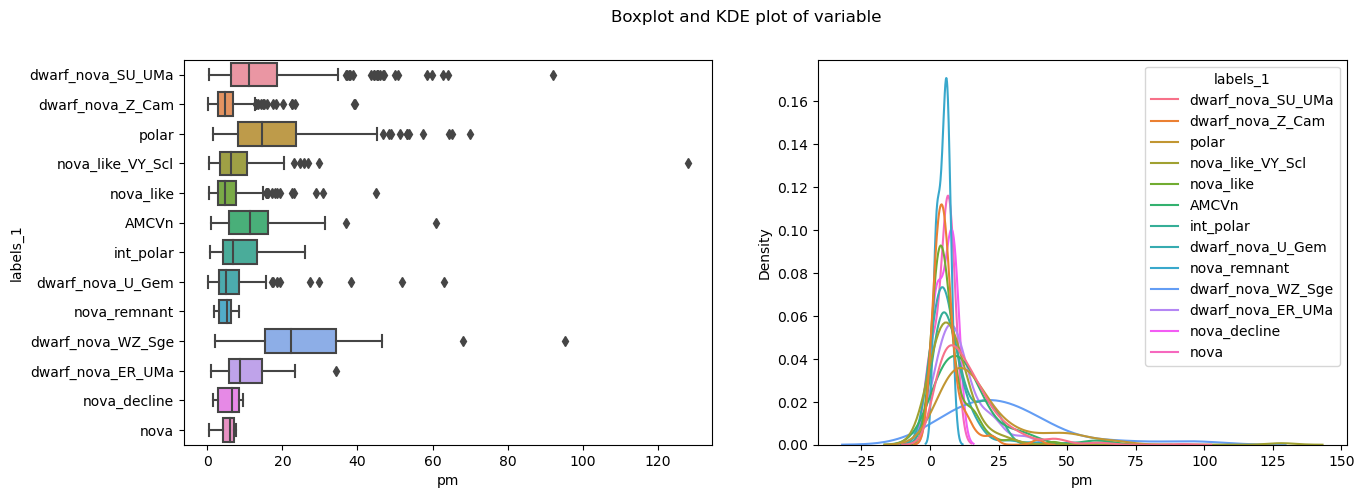

In [35]:
import seaborn as sns
from matplotlib import pyplot as plt
dataframe = gaia_df
name = 'pm'
limits = None
labels = 'labels_1'

droplist = ['Eta_e_r','Freq3_harmonics_rel_phase_3_r','Freq3_harmonics_rel_phase_1_g','Freq1_harmonics_rel_phase_2_r',
            'Freq1_harmonics_rel_phase_3_r','Freq2_harmonics_rel_phase_2_g','Freq3_harmonics_rel_phase_2_r',]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Boxplot and KDE plot of variable')

sns.boxplot(ax=axes[0], data=dataframe, x=name, y=labels)
# sns.stripplot(ax=axes[0], data=dataset, x=name, y='labels_1', color='grey', alpha=0.5)
axes[0].set(xlim=limits)
sns.kdeplot(ax=axes[1], x=name, data=dataframe, hue=labels, common_norm=False)
axes[1].set(xlim=limits)


### Get mutual information, VIF and ANOVA scores

In [ ]:
# Get mutual information scores for g band light curve features

# Get mutual information scores for r band light curve features

# Get mutual information scores for gaia features

# Get ANOVA scores for g band light curve features

# Get ANOVA scores for r band light curve features

# Get ANOVA scores for gaia features